# Tavily 网络搜索 + LangGraph

In [2]:
! pip install -U langgraph langchain-openai tavily-python langchain-community

  Obtaining dependency information for langgraph from https://files.pythonhosted.org/packages/19/e5/7d5dd9d5baf949b5ebfc932de59272ea12d42b0e1b14bbbd93d63e1fc1fe/langgraph-0.2.70-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-openai from https://files.pythonhosted.org/packages/a3/24/a57c061a6738b89f44aa48d756945b011867cedba9a94d48729def22155c/langchain_openai-0.3.4-py3-none-any.whl.metadata
  Obtaining dependency information for tavily-python from https://files.pythonhosted.org/packages/a5/cd/71088461d7720128c78802289b3b36298f42745e5f8c334b0ffc157b881e/tavily_python-0.5.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 868.7 kB/s eta 0:00:00 0:00:01
  Obtaining dependency information for langchain-core!=0.3.0,!=0.3.1,!=0.3.10,!=0.3.11,!=0.3.12,!=0.3.13,!=0.3.14,!=0.3.15,!=0.3.16,!=0.3.17,!=0.3.18,!=0.3.19,!=0.3.2,!=0.3.20,!=0.3.21,!=0.3.22,!=0.3.3,!=0.3.4,!=0.3.5,!=0.3.6,!=0.3.7,!=0.3.8,!=0.3.9,<0.4.0,>=0.2.43 from https://

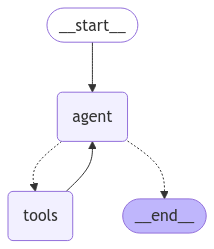

================================ Human Message =================================

2024年北京程序员的平均薪酬
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_kKPK83CMdPeBE8A1Ch2QkMWj)
 Call ID: call_kKPK83CMdPeBE8A1Ch2QkMWj
  Args:
    query: 2024年北京程序员平均薪酬
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.csdn.net/2401_83977825/article/details/137212400", "content": "2024年10月程序员薪资出炉，北京最高工资达45000元！ 原创 ... 先从地域上来看，城市的平均工资排行，依然是北上深占据着前三位，其中北京以18094.3的平均工资"}]
================================== Ai Message ==================================

根据最新的数据，2024年北京程序员的平均薪酬为18,094.3元。


In [3]:
import os
from dotenv import load_dotenv
# langgraph chat
from typing import TypedDict, Annotated, Dict, List, Literal
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults

# 初始化 langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "default"

# https://smith.langchain.com

# Tavily API Key
os.environ["TAVILY_API_KEY"] = "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"

# https://app.tavily.com/

# 加载 .env 文件
load_dotenv()


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


tools = [TavilySearchResults(max_results=1)]
model_with_tools = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"),
                              openai_api_base=os.getenv("OPENAI_API_BASE")).bind_tools(tools)

tools_node = ToolNode(tools)
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tools_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", "agent")
app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

for chunk in app.stream(
        {"messages": [("human", "2024年北京程序员的平均薪酬")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()